<script src="https://kit.fontawesome.com/a15c4ad9d3.js" crossorigin="anonymous"></script>
<img src="../../../notebook_banner.png" width="1024" style="float:center">

# Análisis del dataset `insurance` (Kaggle)

<div style="margin-top:10px;">
    <a href="https://www.linkedin.com/in/bruno-angles/" targer="_blank">
        <i class="fa fa-brands fa-linkedin"
           style="background-color:#4875B4;
                  border-radius:2px;
                  color:white;
                  font-size:1.1em;
                  padding:2px;
                  margin-right:5px" />
    </a>
    <i>Por Bruno Anglés (10/12/2022)</i>
</div>


En este ejercicio realizaremos un análisis del dataset de Kaggle `mirichoi0218/insurance`. 

El objetivo que perseguimos es el de formular algunas hipótesis para entrenar un algoritmo de regresión.

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Configurar estilos de seaborn
sns.set()

## Importación del dataset

In [3]:
insurance = pd.read_csv("insurance.csv")

## Exploración del dataset

In [4]:
# Tamaño del dataset
insurance.shape

(1338, 7)

In [5]:
# Columnas y tipos de datos
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Variables numéricas**

- `age`: edad del beneficiario de la póliza
- `bmi`: índice de masa corporal del beneficiario de la póliza
- `children`: número de hijos cubiertos por la póliza
- `charges`: costes médicos facturados

**Variables categóricas**

- `sex`: sexo del beneficiario de la póliza
- `smoker`: Indica si el beneficiario es o no fumador
- `region`: área de residencia del beneficiario

In [6]:
# Mostrar estadísticas para las variables numéricas
insurance.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [7]:
age_min = int(insurance.age.min())
age_max = int(insurance.age.max())
print(f"La edad del beneficiario está entre los {age_min} y los {age_max}")

children_median = int(insurance.children.median())
children_max = int(insurance.children.max())
print(f"El promedio del número de hijos es de {children_median}, el máximo de {children_max}")

charges_min = float(insurance.charges.min())
charges_max = float(insurance.charges.max())
charges_range = charges_max - charges_min
charges_range_magnitude = math.floor(math.log(charges_range, 10))
print(f"La diferencia de los costes médicos tiene un orden de magnitud de {charges_range_magnitude},"
      f" de {charges_min:.2f} a {charges_max:.2f}")

La edad del beneficiario está entre los 18 y los 64
El promedio del número de hijos es de 1, el máximo de 5
La diferencia de los costes médicos tiene un orden de magnitud de 4, de 1121.87 a 63770.43


In [8]:
# Mostrar estadísticas para las variables categóricas
insurance.describe(include="object").transpose()

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [9]:
sex_values = set(insurance.sex.values)
print("sex:", sex_values)

smoker_values = set(insurance.smoker.values)
print("smoker:", smoker_values)

region_values = set(insurance.region.values)
print("region:", region_values)

sex: {'female', 'male'}
smoker: {'yes', 'no'}
region: {'northwest', 'southwest', 'northeast', 'southeast'}


## Limpieza del dataset

In [10]:
# Registros duplicados
shape_pre = insurance.shape
shape_post = insurance.drop_duplicates().shape
print("Tamaño del data set original:",shape_pre)
print("Tamaño del dataset sin duplicados:", shape_post)

if shape_pre != shape_post:
    print("Se han detectado registros duplicados, se van a eliminar")
    insurance = insurance.drop_duplicates()

Tamaño del data set original: (1338, 7)
Tamaño del dataset sin duplicados: (1337, 7)
Se han detectado registros duplicados, se van a eliminar


In [11]:
# Valores nulos
insurance.isnull().sum()

# No se han detectado valores nulos, por lo tanto no es necesario realizar una limpieza

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Visualización del dataset

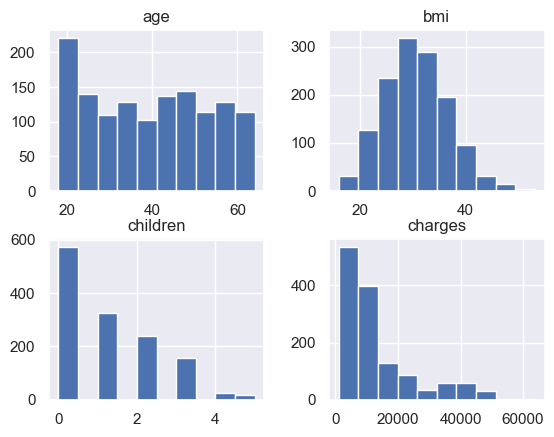

In [12]:
# Mostrar la distribución por columnas
insurance.hist()
plt.show()

- La vaiable `age` está distribuida de forma bastante uniforme aunque llama la atención la gran cantidad de beneficiarios que con edad menor o igual la 20 años, ya que [según un estudio](http://www.dgsfp.mineco.es/es/Publicaciones/DocumentosPublicaciones/Informe%20del%20Sector%202020.pdf) en España este tramo de edad sólo representa el `0,04%`.

In [13]:
total = len(insurance)
ins_by_age = insurance[["age", "charges"]].groupby("age").count()
ins_by_age["ratio"] = ins_by_age.charges.apply(lambda x: x / total).map('{:,.3f}%'.format)
ins_by_age.nlargest(3, "charges")

,charges,ratio
age,,
18,69,0.052%
19,67,0.050%
20,29,0.022%


- La variable `bmi` (índice de masa corporal) parece distribuirse de forma normal, tal como se esperaría.

- Respecto a la variable `children` vemos que el valor mayoritario es de cero lo cuál es coherente con lo que hemos visto respecto a la variable `age`. Ya que lo normal es que los menores de 20 años no tengan hijos.

In [14]:
ins_by_children = insurance[["children", "charges"]].groupby("children").count()
ins_by_children["ratio"] = ins_by_children.charges.apply(lambda x: x / total).map('{:,.3f}%'.format)
ins_by_children.nlargest(3, "charges")

,charges,ratio
children,,
0,573,0.429%
1,324,0.242%
2,240,0.180%


<div class="alert-block alert alert-info">
    <p style="font-weight: bold;">
        <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
        Variable children como categórica
    </p>
    <p>
        El patrón en columnas tan peculiar de la variable <i>children</i> podría ser categórica. Esto tendría el inconveniente de que el modelo no podría predecir el coste en el caso que el abonado tuviera más de 5 hijos.
    </p>
    <p>
        Para decidir si es conveniente consierararla categórica o no deberíamos investigar algo más. No obstante, dado que más adelante se considera que esta variable va a ser poco significativa de cara al modelo de regresión, se va a dejar como numérica.
    </p>
</div>

- Vemos que la mayoría de los costes médicos están por debajo de los `$20.000`. 

<div class="alert alert-block alert-info">
    <p style="font-weight: bold;">
        <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
        Variable objetivo
    </p>
    <p>
        Esta va a ser nuestra variable objetivo. El objetivo de este análisis es el de determinar qué variables pueden ser más significativas de cara a construir un modelo de regresión lineal capaz de predecir de la forma más eficaz posible el <strong>coste médico asociado a una determinada póliza</strong>
    </p>
</div>

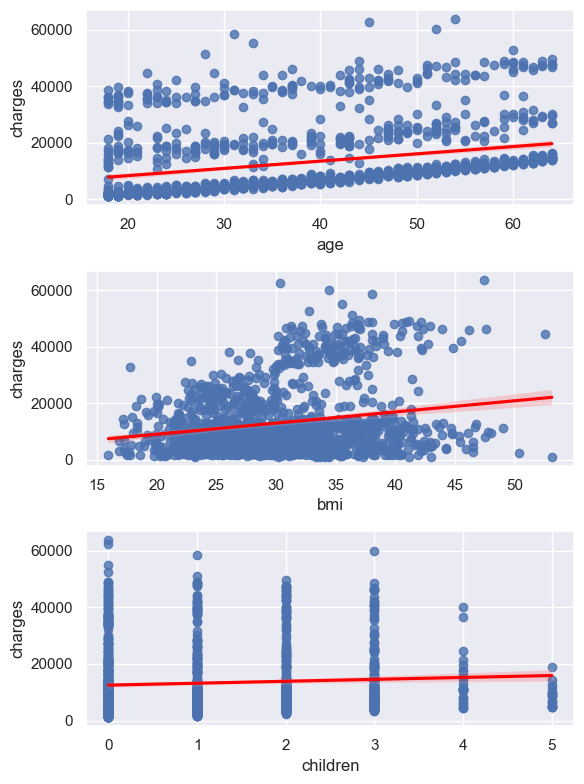

In [15]:
numerical_vars = insurance.columns[insurance.dtypes != "object"]
target = "charges"

fig, axes = plt.subplots(nrows=len(numerical_vars) - 1, ncols=1, figsize=(6,8))

for i, v in enumerate(numerical_vars):
    if v == target:
        continue
    sns.regplot(data=insurance, x=v, y=target, ax=axes[i], line_kws={"color":"red"}, fit_reg=True)
    
fig.tight_layout()

<a id="fact_num_estimators">[1]</a>
A la vista de los anteriores gráfcos, parece que tanto la *edad* (`age`) como el *índice de masa corporal* (`bmi`) son buenos predictores de los costes en salud (`charges`) . En cambio, el gráfico de dispersión tan característico de la variable *número de hijos* (`children`) sugiere que puede no ser un buen estimador. 

A continuación nos vamos a centrar en analizar cuál es el comportamiento de los *costos* en función del *número de hijos* 

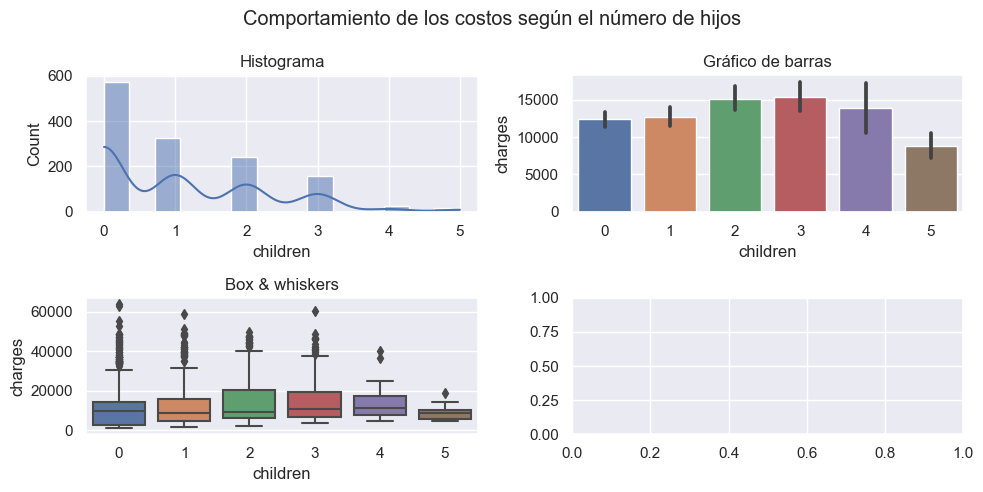

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

plt.suptitle("Comportamiento de los costos según el número de hijos")

ax1 = axes[0,0]
ax1.set_title("Histograma")
sns.histplot(insurance.children, kde=True, ax=ax1)

ax2 = axes[0,1]
ax2.set_title("Gráfico de barras")
sns.barplot(data=insurance, x="children", y="charges", ax=ax2)

ax3 = axes[1,0]
ax3.set_title("Box & whiskers")
sns.boxplot(data=insurance, x="children", y="charges", ax=ax3)
fig.tight_layout()

Estas visualizaciones confirman un poco lo visto en [[1]](#fact_num_estimators). Vemos que no hay apenas diferencia entre los valores más comunes para el *número de hijos* (0 y 1). La mayor diferencia la vemos en el caso de *5 hijos*, que es el caso menos frecuente.

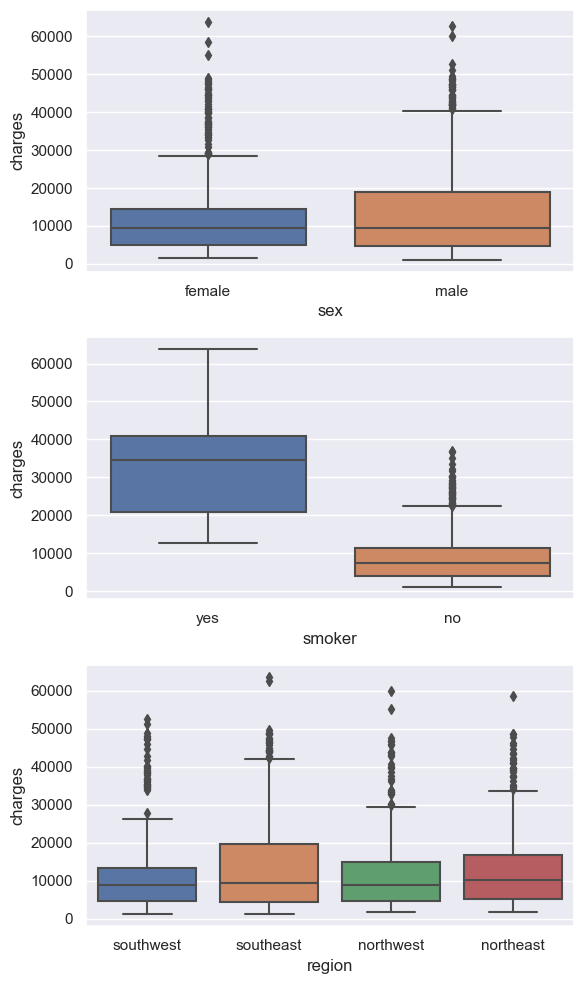

In [17]:
# Mostrar la distribución de los costes según las variables categóricas

categorical_vars = list(insurance.columns[insurance.dtypes == "object"])
target = "charges"

fig, axes = plt.subplots(nrows=len(categorical_vars), ncols=1, figsize=(6,10))

for i, v in enumerate(categorical_vars):
    sns.boxplot(data=insurance, y=target, x=v, ax=axes[i])
    
fig.tight_layout()

<a id="fact_cat_estimators">[2]</a>
A la vista de los gráficos anteriores, parece que el hecho de *ser o no fumador* (`smoker`) influye mucho en el importre de los *costes médicos* (`charges`) ya que el *coste promedio* es significativamente mayor en el caso de los fumadores.

En cambio no parece haber una gran diferencia respecto al *sexo* (`sex`) y el área geográfica (`region`).

Por [[1]](#fact_num_estimators) y [[2]](#fact_cat_estimators) parece interesante observar la dispersión de `charges` versus cada una de las variables numéricas, distinguiendo según `smoker`

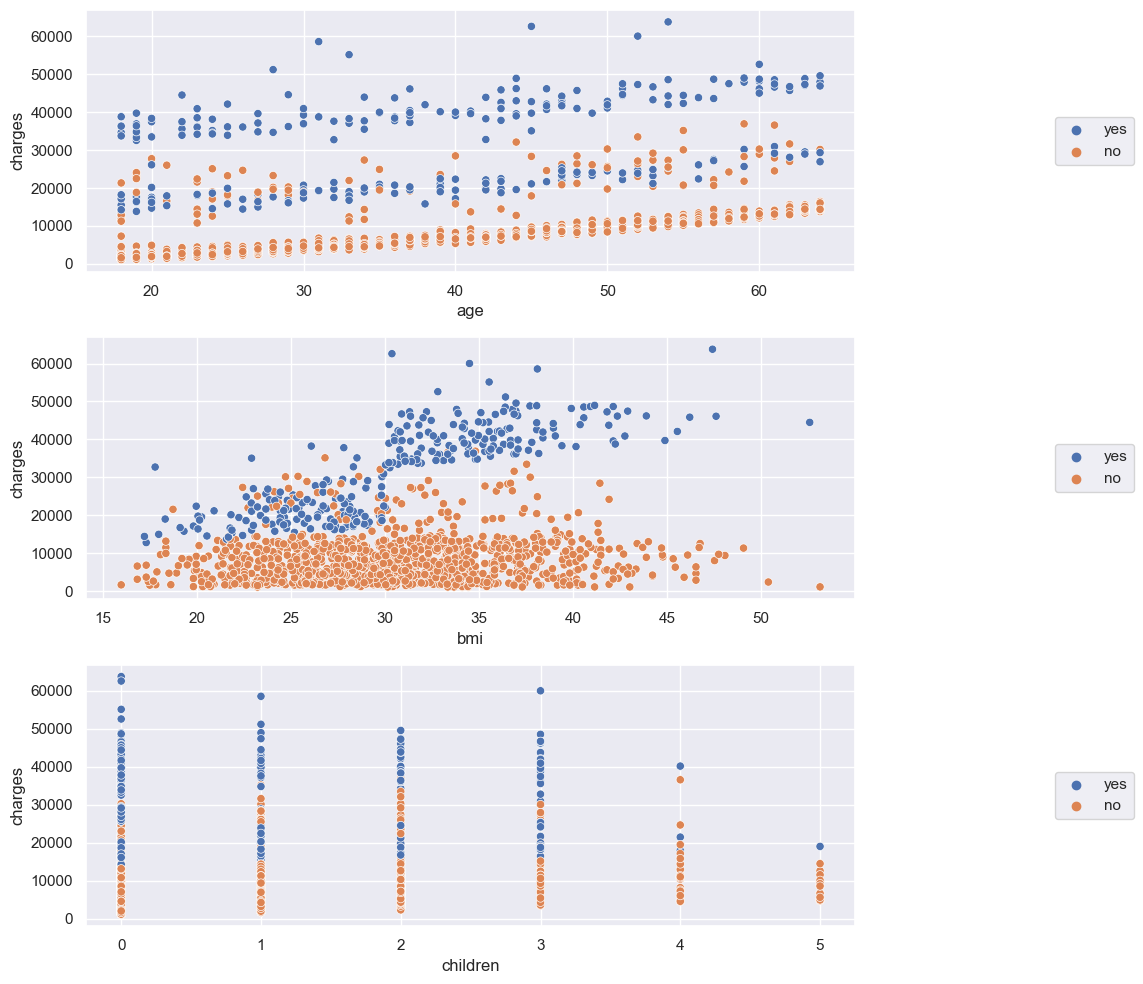

In [18]:
# Diagrama de dispersión de las variables numéricas en función de la variable smoker
fig, axes = plt.subplots(nrows=len(numerical_vars) - 1, ncols=1, figsize=(12,10))

for i, v in enumerate(numerical_vars):
    if v == target:
        continue
    g = sns.scatterplot(data=insurance, x=v, y=target, ax=axes[i], hue="smoker")
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    
fig.tight_layout()
    

<a id="fact_smoker_estimator">[3]</a>
A la vista de los gráficos anteriores, parece que la variable `smoker` separa muy bien los datos, con lo que puede ser un buen estimador de los *costes* (`charges`)

/var/folders/jy/88_thsfj3xx4wvtlz4y08p6m7s11b_/T/ipykernel_52375/3715858277.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = insurance.corr()


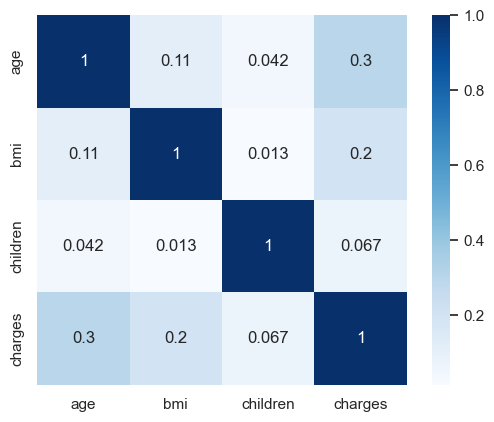

In [19]:
# Diagrama de correlación
corr = insurance.corr()
sns.heatmap(corr, cmap="Blues", annot=True, square=True)
plt.show()

El diagrama de correlación confirma la intuición que teníamos en [[1]](#fact_num_estimators), de que `charges` tiene una correlación moderada con `age` y `bmi`.

<a id="fact_corr_age_bmi">[4]</a>
También vemos una correlación algo más débil entre `age` y `bmi`. Esta correlación es directa e indicaría que el *a mayor edad mayor índice de masa corporal*

# Hipótesis para entrenar un modelo de regresión

Planteamos un modelo de **regresión múltiple** para predecir los costes médicos de una determinada póliza (`charges`).

Para ello proponemos las siuguientes hipótesis de trabajo.

- **Hipótesis 1**: entrenar el modelo sólo con las variables numéricas
    - **Hipótesis 1 (b)**: escalar el valor de `charges`
- **Hipótesis 2**: usar tanto las variables numéricas como las categóricas (mediante *one hot encodding*) para entrenar el modelo
    - **Hipótesis 2 (b)**: escalar el valor de `charges`
- **Hipótesis 3**: entrenar el modelo sólo con las variables que hemos encontrado significativas en [[1]](#fact_num_estimators), [[2]](#fact_cat_estimators) y [[3]](#fact_smoker_estimator): `age, bmi, smoker`
    - **Hipótesis 3 (b)**: escalar el valor de `charges`
- **Hipótesis 4**: entrenar un modelo super-reducido teniendo en cuenta sólo `bmi`y `smoker`para predecir `charges`. En en este modelo eliminaríamos la variable `age` ya que según [[4]](#fact_corr_age_bmi) hay una ligera correlación entre la *edad* y el *índice de masa corporal*.
    - **Hipótesis 4 (b)**: escalar el valor de `charges`


## Entrenamiento del modelo de regresión lineal múltiple

## Hipótesis 1. Variables numéricas

In [20]:
# Preparamos el dataset para la hipótesis 1

data_hip01 = insurance[numerical_vars]
X_hip01 = data_hip01.drop(target, axis=1)
y_hip01 = data_hip01[target]

print("X shape", X_hip01.shape)
print("y shape", y_hip01.shape)

X shape (1337, 3)
y shape (1337,)


In [21]:
X = X_hip01
y = y_hip01

In [22]:
# Separamos el dataset en conjunto de entrenamiento y de test


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2001)
print(f"Training set. X: {X_train.shape}, y:{y_train.shape}")
print(f"Test set. X: {X_test.shape}, y:{y_test.shape}")

Training set. X: (1069, 3), y:(1069,)
Test set. X: (268, 3), y:(268,)


In [23]:
# Entrenamos el modelo
mlr_hip01 = LinearRegression()
mlr_hip01.fit(X_train, y_train)

LinearRegression()